<a href="https://colab.research.google.com/github/Vaycold/Python_ML/blob/main/Reco_Algo/Embedding%26Ranking.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Goal :
  - Large-scale에서 적용 가능한 추천시스템 구조 이해
  - Word2vec 기반 임베딩
  - EDA에서 도출되는 다양한 INSIGHT
  - [Point-Wise] 모델링
  - Factorization Machine 알고리즘
  - ML에 활용할 수 있는 데이터 변환
  - 추천결과 평가방법

### Word2Vec

   - 임베딩 방법론 중 가장 대중적이고 성능이 좋은 방법
   - 같은 문장 내 혹은 비슷한 위치에 등장하는 단어들을 유사한 의미를 가지고 있을 것이라는 가정
   - 원래는 단어를 벡터로 표현하는 방법으로 고안되었지만, word2vec의 메커니즘을 다양하게 활용할 수 있음.
   - Word2Vec은 중심 단어와 주변 단어와의 연관성을 학습하여 벡터로 표현함.

In [71]:
import pandas as pd

# rating dataset

rating_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/ratings.dat'
rating_df  = pd.io.parsers.read_csv(rating_url, names = ['user_id', 'movie_id', 'rating','time'], delimiter = '::',engine='python')

# movies dataset

movie_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/movies.dat'
movie_df  =  pd.io.parsers.read_csv(movie_url, names = [ 'movie_id', 'title','genre'], delimiter = '::',engine='python', encoding='ISO-8859-1')

# user dataset

user_url = 'https://raw.githubusercontent.com/yoonkt200/python-data-analysis/master/data/ml-1m/users.dat'
user_df  = pd.io.parsers.read_csv(user_url, names = ['user_id', 'gender', 'age','occupation','zipcode'], delimiter = '::',engine='python')

In [72]:
# 시간에 따라 사용자별 시청 목록 추출
def get_movie_list_sory_by_time(x) :
    return x.sort_values(['time'])['movie_id'].tolist()


user_watch_list = rating_df.groupby('user_id')[['movie_id','time']].apply(
    lambda x : get_movie_list_sory_by_time(x)
) # 여기서 movie_id, time은 apply의 영향을 받는 column 들임.

In [73]:
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

In [74]:
rating_df['movie_id'].value_counts()

2858    3428
260     2991
1196    2990
1210    2883
480     2672
        ... 
3323       1
624        1
763        1
2484       1
133        1
Name: movie_id, Length: 3706, dtype: int64

In [75]:
# 영화의 개봉년도 feature 생성
movie_df.head()

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


In [76]:
movie_df['released_year_area'] = movie_df['title'].apply(
    lambda x : x[-5:-2] + '0'
)
movie_df.head()

,movie_id,title,genre,released_year_area
0,1,Toy Story (1995),Animation|Children's|Comedy,1990
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990
2,3,Grumpier Old Men (1995),Comedy|Romance,1990
3,4,Waiting to Exhale (1995),Comedy|Drama,1990
4,5,Father of the Bride Part II (1995),Comedy,1990


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


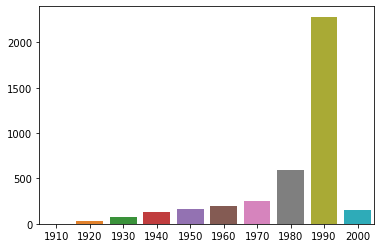

In [77]:
import seaborn as sns
released_year_area = movie_df['released_year_area'].value_counts().sort_index() # sort_index를 함으로써 시간순으로 볼 수 있게 됨.
sns.barplot(released_year_area.index, released_year_area.values)

In [78]:
# 영화 장르 feature 생성
movie_df['genre'].value_counts()

Drama                                 843
Comedy                                521
Horror                                178
Comedy|Drama                          162
Comedy|Romance                        142
                                     ... 
Action|Sci-Fi|Thriller|Western          1
Adventure|Children's|Drama|Romance      1
Crime|Mystery                           1
Adventure|Musical                       1
Comedy|Crime|Fantasy                    1
Name: genre, Length: 301, dtype: int64

In [79]:
movie_df['main_genre'] = movie_df['genre'].apply(lambda x : x.split("|")[0])
movie_df['main_genre'].value_counts()

Drama          1176
Comedy         1024
Action          503
Horror          262
Adventure       155
Crime           131
Documentary     123
Thriller        101
Animation        90
Children's       89
Romance          50
Sci-Fi           46
Mystery          36
Western          33
Film-Noir        25
Musical          25
War              12
Fantasy           2
Name: main_genre, dtype: int64

In [80]:
# movie2vec 학습
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [81]:
movie_meta_dict = movie_df.set_index('movie_id')[['released_year_area','main_genre']]
movie_meta_dict.head(2)

,released_year_area,main_genre
movie_id,,
1,1990,Animation
2,1990,Adventure


In [82]:
movie_meta_dict = movie_meta_dict.to_dict()

In [83]:
movie_meta_dict

{'main_genre': {1: 'Animation',
  2: 'Adventure',
  3: 'Comedy',
  4: 'Comedy',
  5: 'Comedy',
  6: 'Action',
  7: 'Comedy',
  8: 'Adventure',
  9: 'Action',
  10: 'Action',
  11: 'Comedy',
  12: 'Comedy',
  13: 'Animation',
  14: 'Drama',
  15: 'Action',
  16: 'Drama',
  17: 'Drama',
  18: 'Thriller',
  19: 'Comedy',
  20: 'Action',
  21: 'Action',
  22: 'Crime',
  23: 'Thriller',
  24: 'Drama',
  25: 'Drama',
  26: 'Drama',
  27: 'Drama',
  28: 'Romance',
  29: 'Adventure',
  30: 'Drama',
  31: 'Drama',
  32: 'Drama',
  33: 'Adventure',
  34: "Children's",
  35: 'Drama',
  36: 'Drama',
  37: 'Documentary',
  38: 'Comedy',
  39: 'Comedy',
  40: 'Drama',
  41: 'Drama',
  42: 'Action',
  43: 'Drama',
  44: 'Action',
  45: 'Comedy',
  46: 'Drama',
  47: 'Crime',
  48: 'Animation',
  49: 'Drama',
  50: 'Crime',
  51: 'Action',
  52: 'Comedy',
  53: 'Drama',
  54: "Children's",
  55: 'Drama',
  56: 'Adventure',
  57: 'Drama',
  58: 'Drama',
  59: 'Drama',
  60: 'Adventure',
  61: 'Drama',


In [84]:
user_watch_list

user_id
1       [3186, 1721, 1022, 1270, 2340, 1836, 3408, 120...
2       [1198, 1217, 1210, 2717, 1293, 2943, 1225, 119...
3       [593, 2858, 3534, 1968, 1961, 1431, 1266, 1378...
4       [1210, 1097, 3468, 3527, 480, 260, 1196, 1198,...
5       [2717, 919, 908, 356, 1250, 2188, 2858, 1127, ...
                              ...                        
6036    [1721, 2376, 3438, 2428, 1883, 2492, 2827, 268...
6037    [1882, 2028, 1267, 702, 3508, 562, 3148, 858, ...
6038    [920, 3396, 1210, 2146, 356, 1387, 1079, 1148,...
6039    [111, 282, 2067, 930, 1230, 3133, 3022, 947, 3...
6040    [858, 2384, 593, 1961, 2019, 573, 3111, 3505, ...
Length: 6040, dtype: object

In [85]:
'''
ex ) 
    역시 성공은 고난을 동반  
 -> [역시, 성공, 고난, 동반]
  = [movie_id :1, genre: drama, ...]
'''
movie2vec_dataset = []
for movie_list in user_watch_list :
    meta_list = []
    for movie_id in movie_list :
        word_meta_1 = 'movie_id:' + str(movie_id)
        word_meta_2 = 'year:' + movie_meta_dict['released_year_area'][movie_id]
        word_meta_3 = 'genre:' + movie_meta_dict['main_genre'][movie_id]
        meta_list.append(word_meta_1)
        meta_list.append(word_meta_2)
        meta_list.append(word_meta_3)
    movie2vec_dataset.append(meta_list)

In [86]:
str(movie2vec_dataset)[:300]

"[['movie_id:3186', 'year:1990', 'genre:Drama', 'movie_id:1721', 'year:1990', 'genre:Drama', 'movie_id:1022', 'year:1950', 'genre:Animation', 'movie_id:1270', 'year:1980', 'genre:Comedy', 'movie_id:2340', 'year:1990', 'genre:Romance', 'movie_id:1836', 'year:1990', 'genre:Drama', 'movie_id:3408', 'yea"

In [87]:
!pip install gensim

In [88]:
from gensim.models import Word2Vec

model = Word2Vec(movie2vec_dataset,
                 size = 100,
                 window = 6,          # 주변 word의 window                          : 주변의 단어를 몇개 볼 것이냐
                 sg = 1,              # SKIP-gram OR Cbow                           : skip-gram 방식을 쓰겠다 = 1  
                 hs = 0,              # hierachical softmax OR negative sampling    : negative sampling을 쓰겠다 = 0 
                 negative = 20,       # negative sampling parameter
                 min_count = 1,       # word의 등장 최소 횟수
                 iter = 20)

In [89]:
model.wv.most_similar('movie_id:1', topn=5)

[('movie_id:1223', 0.8242529034614563),
 ('movie_id:3429', 0.7438648343086243),
 ('movie_id:2324', 0.7183550596237183),
 ('movie_id:2289', 0.6870214343070984),
 ('movie_id:1537', 0.6640381813049316)]

In [90]:
movie_df[movie_df['movie_id'].isin([1223,3429,2324,2289,3114])]

,movie_id,title,genre,released_year_area,main_genre
1205,1223,"Grand Day Out, A (1992)",Animation|Comedy,1990,Animation
2220,2289,"Player, The (1992)",Comedy|Drama,1990,Comedy
2255,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama,1990,Comedy
3045,3114,Toy Story 2 (1999),Animation|Children's|Comedy,1990,Animation
3360,3429,Creature Comforts (1990),Animation|Comedy,1990,Animation


In [91]:
movie_df.head(4)

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy


In [92]:
# movie2vec 모델로 item2item 후보군 생성
item2item = {}
k = 10 # 연관영화 추출 갯수
not_in_count = 0
for movie_id in movie_df['movie_id'].values :
    item2item[movie_id] = []
    try :
        sim_list = model.wv.most_similar('movie_id:' + str(movie_id), topn=k+10)
        for movie_tup in sim_list :
            tup_info = movie_tup[0].split(":")
            if (tup_info[0] == 'movie_id') and (len(item2item[movie_id])  <10 ) :
                item2item[movie_id].append(tup_info[1])
    except :
        not_in_count += 1
        print("word", str(movie_id) ,"not in vocabulary")

word 51 not in vocabulary
word 109 not in vocabulary
word 115 not in vocabulary
word 143 not in vocabulary
word 284 not in vocabulary
word 285 not in vocabulary
word 395 not in vocabulary
word 399 not in vocabulary
word 400 not in vocabulary
word 403 not in vocabulary
word 604 not in vocabulary
word 620 not in vocabulary
word 625 not in vocabulary
word 629 not in vocabulary
word 636 not in vocabulary
word 654 not in vocabulary
word 675 not in vocabulary
word 676 not in vocabulary
word 683 not in vocabulary
word 693 not in vocabulary
word 699 not in vocabulary
word 713 not in vocabulary
word 721 not in vocabulary
word 723 not in vocabulary
word 727 not in vocabulary
word 738 not in vocabulary
word 739 not in vocabulary
word 752 not in vocabulary
word 768 not in vocabulary
word 770 not in vocabulary
word 772 not in vocabulary
word 773 not in vocabulary
word 777 not in vocabulary
word 794 not in vocabulary
word 795 not in vocabulary
word 797 not in vocabulary
word 812 not in vocabulary
wo

In [93]:
item2item

{1: ['1223',
  '3429',
  '2324',
  '2289',
  '1537',
  '745',
  '3114',
  '1148',
  '720',
  '235'],
 2: ['60',
  '3489',
  '1848',
  '653',
  '1009',
  '126',
  '2162',
  '1015',
  '2429',
  '2143'],
 3: ['804', '2558', '195', '1593', '1409', '236', '276', '370', '237', '2385'],
 4: ['537', '2252', '195', '186', '1167', '637', '2431', '135', '1410', '765'],
 5: ['203', '186', '2082', '2335', '719', '1526', '818', '2249', '445', '830'],
 6: ['2278',
  '555',
  '474',
  '1610',
  '493',
  '3267',
  '2058',
  '2353',
  '1912',
  '3256'],
 7: ['2424', '252', '539', '339', '597', '1409', '1457', '236', '1569', '378'],
 8: ['1015',
  '238',
  '1582',
  '986',
  '1017',
  '609',
  '1806',
  '362',
  '2103',
  '2899'],
 9: ['315', '227', '459', '479', '1382', '694', '548', '1004', '20', '1438'],
 10: ['349',
  '733',
  '1049',
  '1552',
  '2273',
  '1370',
  '494',
  '2334',
  '1047',
  '3256'],
 11: ['2671',
  '838',
  '2539',
  '342',
  '1693',
  '3255',
  '440',
  '2108',
  '708',
  '1680'

In [94]:
# 평균 평점 기반 popular 후보군 추출

mean_rating = rating_df.groupby('movie_id')['rating'].agg(['mean','count'])
mean_rating

,mean,count
movie_id,,
1,4.146846,2077
2,3.201141,701
3,3.016736,478
4,2.729412,170
5,3.006757,296
...,...,...
3948,3.635731,862
3949,4.115132,304
3950,3.666667,54


In [95]:
mean_rating['count'].value_counts()

1       114
2        89
4        45
3        42
5        39
       ... 
1568      1
1548      1
1546      1
1522      1
1995      1
Name: count, Length: 924, dtype: int64

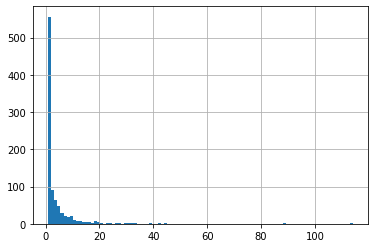

In [96]:
mean_rating['count'].value_counts().hist(bins=100)

In [97]:
mean_rating[ mean_rating['count']>10]['mean'].sort_values(ascending=False)[:20] # Top 20

movie_id
2905    4.608696
2019    4.560510
318     4.554558
858     4.524966
745     4.520548
50      4.517106
527     4.510417
1148    4.507937
922     4.491489
1198    4.477725
904     4.476190
1178    4.473913
260     4.453694
1212    4.452083
750     4.449890
3338    4.444444
720     4.426941
1207    4.425647
3435    4.415608
912     4.412822
Name: mean, dtype: float64

In [98]:
popular_movie_list = mean_rating[ mean_rating['count']>10]['mean'].sort_values(ascending=False)[:10].tolist()
popular_movie_list

[4.608695652173913,
 4.560509554140127,
 4.554557700942973,
 4.524966261808367,
 4.52054794520548,
 4.517106001121705,
 4.510416666666667,
 4.507936507936508,
 4.491489361702127,
 4.477724741447892]

In [99]:
# 장르 & 연도 기준 meta2item 후보군 생성
merge_df = pd.merge(mean_rating,movie_df, on = 'movie_id')
merge_df

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy
...,...,...,...,...,...,...,...
3701,3948,3.635731,862,Meet the Parents (2000),Comedy,2000,Comedy
3702,3949,4.115132,304,Requiem for a Dream (2000),Drama,2000,Drama
3703,3950,3.666667,54,Tigerland (2000),Drama,2000,Drama
3704,3951,3.900000,40,Two Family House (2000),Drama,2000,Drama


In [100]:
# 장르 & 연도를 meta로 하는 상위 10의 rating
def get_meta_popular_list(x, k) :
    movie_id_list = x.sort_values(by=['mean'], ascending=False)['movie_id'].tolist()
    return movie_id_list
genre_popular = merge_df.groupby('main_genre').apply(lambda x : get_meta_popular_list(x, k=10))
year_popular = merge_df.groupby('released_year_area').apply(lambda x : get_meta_popular_list(x, k=10))

In [101]:
genre_popular

main_genre
Action         [2905, 2019, 858, 1198, 260, 1221, 2028, 2571,...
Adventure      [3172, 1204, 1262, 3470, 1254, 919, 1303, 1259...
Animation      [745, 1148, 720, 1223, 3429, 3114, 1, 741, 276...
Children's     [1097, 1028, 34, 262, 3396, 755, 531, 3397, 55...
Comedy         [1830, 3233, 3607, 3030, 3307, 3022, 1136, 341...
Crime          [3656, 50, 3517, 3435, 1260, 296, 1213, 1945, ...
Documentary    [3881, 787, 3338, 2930, 128, 1147, 3679, 363, ...
Drama          [3382, 989, 3245, 53, 2503, 318, 527, 578, 248...
Fantasy                                              [792, 2021]
Film-Noir      [922, 913, 1252, 1267, 1284, 2186, 930, 541, 2...
Horror         [3280, 1219, 1258, 1348, 2648, 1997, 2664, 134...
Musical        [899, 914, 1947, 2565, 3606, 1035, 3545, 900, ...
Mystery        [904, 1212, 903, 950, 906, 1086, 2206, 1625, 9...
Romance        [928, 28, 932, 2708, 2721, 1684, 803, 2833, 33...
Sci-Fi         [750, 1199, 2010, 1206, 1301, 2660, 1921, 3658...
Thriller      

In [102]:
year_popular

released_year_area
1910                                   [3132, 2821, 2823]
1920    [3517, 3022, 3629, 2010, 3232, 1348, 3742, 330...
1930    [3382, 3307, 3134, 1260, 905, 919, 954, 950, 3...
1940    [3656, 1212, 3435, 912, 913, 923, 3089, 1284, ...
1950    [3172, 2019, 922, 904, 1178, 670, 668, 1250, 9...
1960    [3233, 3245, 2905, 557, 750, 1207, 3030, 1204,...
1970    [3607, 3280, 858, 260, 1193, 1221, 1252, 1136,...
1980    [1198, 3338, 1131, 1197, 1233, 2931, 1196, 117...
1990    [989, 787, 1830, 53, 2503, 318, 745, 50, 527, ...
2000    [3881, 3888, 3897, 3949, 3578, 3911, 3647, 335...
dtype: object

In [103]:
genre_popular_dict = genre_popular.to_dict()
year_popular_dict = year_popular.to_dict()

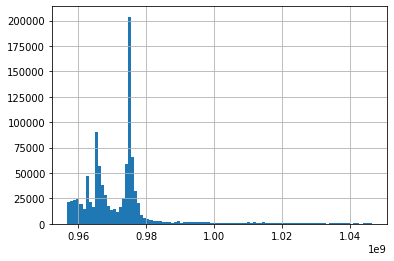

In [104]:
# Point-wise dataset 생성
# 특정 시간 기준 데이터셋 분리
rating_df['time'].hist(bins=100
                       )


In [105]:
rating_df['time'].quantile(0.8, interpolation = 'nearest')

975768738

In [106]:
train_df = rating_df[rating_df['time'] < 975768738]
test_df = rating_df[rating_df['time'] >= 975768738]

In [107]:
# User profiling

In [108]:
import matplotlib.pyplot as plt
user_df.head()

,user_id,gender,age,occupation,zipcode
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


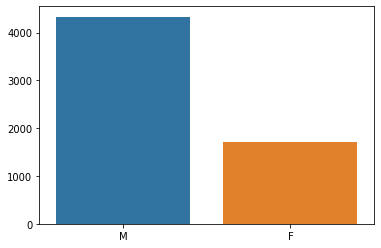

In [109]:
#.1 Gender
gender = user_df['gender'].value_counts()
sns.barplot(gender.index, gender.values)
plt.show()

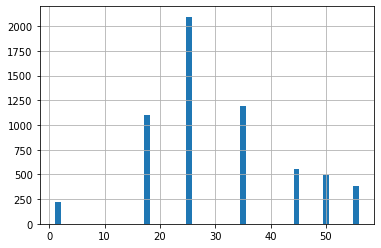

In [110]:
#.2 Age
user_df['age'].hist(bins='auto')

In [111]:
user_df['age'].value_counts()

25    2096
35    1193
18    1103
45     550
50     496
56     380
1      222
Name: age, dtype: int64

In [112]:
def age_bucket(age) :
    if age==1 :
        return 'outlier'
    else :
        return str(age)[0] +'0'
user_df['age_bucket'] = user_df['age'].apply(lambda x : age_bucket(x))
user_df['age_bucket'].value_counts()

20         2096
30         1193
10         1103
50          876
40          550
outlier     222
Name: age_bucket, dtype: int64

In [113]:
#.3 occupation
user_df['occupation'].value_counts()

4     759
0     711
7     679
1     528
17    502
12    388
14    302
20    281
2     267
16    241
6     236
10    195
3     173
15    144
13    142
11    129
5     112
9      92
19     72
18     70
8      17
Name: occupation, dtype: int64

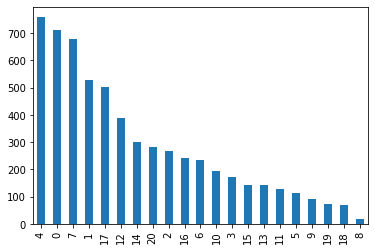

In [117]:
user_df['occupation'].value_counts().plot(kind='bar')
plt.show()

In [118]:
#.4 zipcode
user_df['zipcode'].value_counts()

48104    19
22903    18
94110    17
55104    17
55455    16
         ..
17402     1
22015     1
02865     1
02464     1
02718     1
Name: zipcode, Length: 3439, dtype: int64

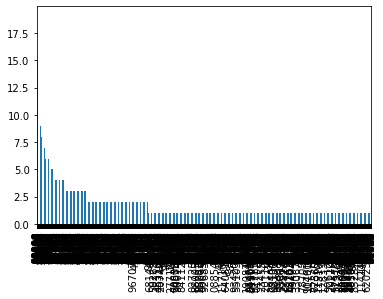

In [119]:
user_df['zipcode'].value_counts().plot(kind='bar')

In [120]:
# 유저 속성별 feature map 생성
user_df.head()

,user_id,gender,age,occupation,zipcode,age_bucket
0,1,F,1,10,48067,outlier
1,2,M,56,16,70072,50
2,3,M,25,15,55117,20
3,4,M,45,7,02460,40
4,5,M,25,20,55455,20


In [122]:
# GENDER

gender_list = user_df['gender'].unique()
gender_index = {}
for idx, gender in enumerate(gender_list) :
    gender_index[gender] = idx+1           # F : 1, M :2
gender_index

{'F': 1, 'M': 2}

In [125]:
 # AGE

age_list = user_df['age_bucket'].unique()
age_index = {}
for idx, age in enumerate(age_list) :
    age_index[age] = idx+1           # F : 1, M :2
age_index

{'10': 6, '20': 3, '30': 5, '40': 4, '50': 2, 'outlier': 1}

In [126]:
# OCCUPATION

occupation_list = user_df['occupation'].unique()
occupation_index = {}
for idx, occupation in enumerate(occupation_list) :
    occupation_index[occupation] = idx+1           
occupation_index

{0: 10,
 1: 7,
 2: 17,
 3: 11,
 4: 13,
 5: 19,
 6: 21,
 7: 4,
 8: 15,
 9: 6,
 10: 1,
 11: 14,
 12: 8,
 13: 20,
 14: 12,
 15: 3,
 16: 2,
 17: 9,
 18: 18,
 19: 16,
 20: 5}

In [128]:
# 영화 속성별 feature map 생성
merge_df.head()

,movie_id,mean,count,title,genre,released_year_area,main_genre
0,1,4.146846,2077,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,3.201141,701,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,3.016736,478,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,2.729412,170,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,3.006757,296,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [130]:
#1. Genre
genre_list = merge_df['main_genre'].unique()
genre_index = {}
for idx, genre in enumerate(genre_list) :
    genre_index[genre] = idx+1
genre_index

{'Action': 4,
 'Adventure': 2,
 'Animation': 1,
 "Children's": 9,
 'Comedy': 3,
 'Crime': 7,
 'Documentary': 10,
 'Drama': 5,
 'Fantasy': 17,
 'Film-Noir': 15,
 'Horror': 12,
 'Musical': 18,
 'Mystery': 14,
 'Romance': 8,
 'Sci-Fi': 11,
 'Thriller': 6,
 'War': 16,
 'Western': 13}

In [131]:
#2. Year
year_list = merge_df['released_year_area'].unique()
year_index = {}
for idx, year in enumerate(year_list) :
    year_index[year] = idx+1
year_index

{'1910': 9,
 '1920': 8,
 '1930': 5,
 '1940': 6,
 '1950': 7,
 '1960': 4,
 '1970': 2,
 '1980': 3,
 '1990': 1,
 '2000': 10}

In [132]:
train_df.head()

,user_id,movie_id,rating,time
94507,635,1251,4,975768620
94513,635,3948,4,975768294
94518,635,1270,4,975768106
94519,635,1279,5,975768520
94522,635,1286,4,975768106


In [133]:
movie_df.head()

,movie_id,title,genre,released_year_area,main_genre
0,1,Toy Story (1995),Animation|Children's|Comedy,1990,Animation
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1990,Adventure
2,3,Grumpier Old Men (1995),Comedy|Romance,1990,Comedy
3,4,Waiting to Exhale (1995),Comedy|Drama,1990,Comedy
4,5,Father of the Bride Part II (1995),Comedy,1990,Comedy


In [134]:
user_df.head()

,user_id,gender,age,occupation,zipcode,age_bucket
0,1,F,1,10,48067,outlier
1,2,M,56,16,70072,50
2,3,M,25,15,55117,20
3,4,M,45,7,02460,40
4,5,M,25,20,55455,20


In [135]:
# Context profiling
train_df = pd.merge(train_df, movie_df, on = 'movie_id')
train_df = pd.merge(train_df, user_df, on = 'user_id')
train_df.head()

,user_id,movie_id,rating,time,title,genre,released_year_area,main_genre,gender,age,occupation,zipcode,age_bucket
0,635,1251,4,975768620,8 1/2 (1963),Drama,1960,Drama,M,56,17,33785,50
1,635,3948,4,975768294,Meet the Parents (2000),Comedy,2000,Comedy,M,56,17,33785,50
2,635,1270,4,975768106,Back to the Future (1985),Comedy|Sci-Fi,1980,Comedy,M,56,17,33785,50
3,635,1279,5,975768520,Night on Earth (1991),Comedy|Drama,1990,Comedy,M,56,17,33785,50
4,635,1286,4,975768106,Somewhere in Time (1980),Drama|Romance,1980,Drama,M,56,17,33785,50


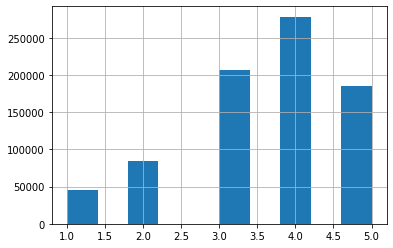

In [136]:
train_df.rating.hist()

In [137]:
# Feature mapping

train_df = train_df[['user_id','movie_id', 'rating', 'released_year_area', 'main_genre','gender','occupation','age_bucket']]
train_df['released_year_area'] = train_df['released_year_area'].apply(lambda x : year_index[x])
train_df['main_genre'] = train_df['main_genre'].apply(lambda x : genre_index[x])
train_df['gender'] = train_df['gender'].apply(lambda x : gender_index[x])
train_df['occupation'] = train_df['occupation'].apply(lambda x : occupation_index[x])
train_df['age_bucket'] = train_df['age_bucket'].apply(lambda x : age_index[x])

In [138]:
train_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2


In [139]:
test_df = pd.merge(test_df, movie_df,on = 'movie_id')
test_df = pd.merge(test_df, user_df,on = 'user_id')
test_df = test_df[['user_id','movie_id', 'rating', 'released_year_area', 'main_genre','gender','occupation','age_bucket']]
test_df['released_year_area'] = test_df['released_year_area'].apply(lambda x : year_index[x])
test_df['main_genre'] = test_df['main_genre'].apply(lambda x : genre_index[x])
test_df['gender'] = test_df['gender'].apply(lambda x : gender_index[x])
test_df['occupation'] = test_df['occupation'].apply(lambda x : occupation_index[x])
test_df['age_bucket'] = test_df['age_bucket'].apply(lambda x : age_index[x])
test_df.head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,1,1193,5,2,5,1,1,1
1,1,661,3,1,1,1,1,1
2,1,914,3,4,18,1,1,1
3,1,3408,4,10,5,1,1,1
4,1,2355,5,1,1,1,1,1


In [140]:
# Binary Transform
# 평가 점수를 기준으로 0과 1로 변환
train_df.head() 

#즉 rating이 평가 기준이 될 것임.


,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket
0,635,1251,4,4,5,2,9,2
1,635,3948,4,10,3,2,9,2
2,635,1270,4,3,3,2,9,2
3,635,1279,5,1,3,2,9,2
4,635,1286,4,3,5,2,9,2


In [141]:
train_df['y'] = train_df['rating'].apply(lambda x : 1 if x >=4 else 0)
train_df.sample(10).head()

,user_id,movie_id,rating,released_year_area,main_genre,gender,occupation,age_bucket,y
148121,685,2100,3,3,3,2,13,3,0
47968,5074,1320,2,1,4,2,10,1,0
699265,4526,296,4,1,7,2,5,3,1
341327,3675,3028,3,4,3,2,4,5,0
782098,3377,6,4,1,4,2,9,3,1


In [143]:
 # libsvm 포맷
 # index : value 형태로 sparser vector를 표현하는 형태

 col_len_dict = {
     'user_id' : len(train_df.user_id.unique()),
     'movie_id' : len(train_df.movie_id.unique()),
     'released_year_area' : len(train_df.released_year_area.unique()),
     'main_genre' : len(train_df.main_genre.unique()),
     'gender' : len(train_df.gender.unique()),
     'occupation' : len(train_df.occupation.unique()),
     'age_bucket' : len(train_df.age_bucket.unique()),
 }
 col_len_dict
 col_accum_index_dict = {}
 cumulative = 0
 for key, value in col_len_dict.items() :
     col_accum_index_dict[key] = cumulative
     cumulative = cumulative + value
 # 하나의 벡터로 만들기 위해 누적값을 갖는 것임.

In [145]:
for idx, row in train_df.iterrows() :
    vec = []
    label = row['y']
    vec.append(str(label))
    row = row.drop(labels=['rating'])
    row = row.drop(labels=['y'])
    for key, value in row.items() :
        col_idx = col_accum_index_dict[key] + value -1
        vec.append(str(col_idx) + ":" + str(1))
    print("%s\n" % " ".join(vec))
    break

1 634:1 6650:1 9065:1 9076:1 9091:1 9100:1 9114:1



In [146]:
# 추천 랭킹 모델링
# !![Factorization Machine]!!

# Linear regression, SVM처럼 동작하는 General predictor
# 변수 간 모든 pair-wise interaction을 계산하는 알고리즘
# General predictor의 장점 + MF 알고리즘이 가지는 의미 단위 해석(lantent factor)의 장점
# sparse한 데이터셋을 가지고 있을 때의 적합

!pip install xlearn


     |████████████████████████████████| 4.9MB 6.8MB/s 
  Created wheel for xlearn: filename=xlearn-0.40a1-cp37-none-any.whl size=228554 sha256=e59b9e2445b49e734e40c4b97b1b51ad7099fce40d5d55d2340cbff2592638e9
  Stored in directory: /root/.cache/pip/wheels/59/7d/71/699578f3cb69f16a2e5f648d978259dba959c92a5a6eca9451
Successfully built xlearn
